In [437]:
# multivariate output data prep
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
#import preprocessing

In [438]:
np.random.seed(7)

In [439]:
# IMPORTING DATASET 
#dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])
#dataset = pd.read_csv('Stock_with_label.csv', usecols=[1,2,3,4,5])
#dataset = pd.read_csv('Stock_with_label_sa.csv', usecols=[1,2,3,4,5])
dataset = pd.read_csv('AE_MSFT_SA.csv', usecols=[1,2,3,4,5])
#dataset = pd.read_csv('Stock_new_with_AELabel.csv', usecols=[1,2,3,4,5])
dataset = dataset.reindex(index = dataset.index[::-1])
print(dataset)
dataset.shape
dataset = dataset.values #return the numpy representation of the given DataFrame.
dataset = dataset.astype('float32')

           Open       High        Low      Close  Label
4150  51.130001  51.720001  51.070000  51.160000      1
4149  50.720001  51.299999  50.500000  51.169998      1
4148  49.910000  50.720001  49.799999  50.540001      1
4147  48.919998  49.470001  48.669998  49.439999      1
4146  49.099998  49.150002  48.040001  48.430000      0
4145  49.810001  50.939999  49.520000  49.830002      0
4144  51.279999  52.060001  51.150002  51.910000      1
4143  51.080002  51.459999  50.950001  50.990002      0
4142  50.200001  51.430000  50.160000  51.189999      1
4141  50.639999  50.830002  50.029999  50.070000      1
4140  50.410000  50.430000  49.820000  50.130001      0
4139  49.520000  50.470001  49.509998  50.389999      1
4138  49.779999  50.119999  49.689999  49.689999      0
4137  49.900002  50.099998  49.570000  49.830002      0
4136  49.580002  50.720001  49.060001  50.139999      0
4135  51.049999  52.049999  51.040001  51.480000      0
4134  52.000000  52.000000  51.490002  51.619999

In [440]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [441]:
# split into train and test sets
train_size = int(len(dataset) * 0.80) #1114
test_size = len(dataset) - train_size #550
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train.shape) # (1114,4)
print(test.shape) #(550,4)

(3320, 5)
(831, 5)


In [442]:
# split a multivariate sequence into samples
def create_dataset(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [443]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(3318, 2, 5)
(3318, 5)
(829, 2, 5)
(829, 5)


In [444]:
print(trainX)

[[[0.82621455 0.82622874 0.87397385 0.8348935  1.        ]
  [0.8167865  0.81661606 0.8602123  0.8351254  1.        ]]

 [[0.8167865  0.81661606 0.8602123  0.8351254  1.        ]
  [0.79816043 0.8033415  0.84331226 0.8205188  1.        ]]

 [[0.79816043 0.8033415  0.84331226 0.8205188  1.        ]
  [0.7753953  0.7747325  0.81603074 0.79501516 1.        ]]

 ...

 [[0.24029896 0.24420667 0.25808784 0.25387627 0.        ]
  [0.23776951 0.23642504 0.2527764  0.24506593 0.        ]]

 [[0.23776951 0.23642504 0.2527764  0.24506593 0.        ]
  [0.24213853 0.23482287 0.25060353 0.24158818 1.        ]]

 [[0.24213853 0.23482287 0.25060353 0.24158818 1.        ]
  [0.24719754 0.2432912  0.260985   0.2469207  1.        ]]]


In [445]:
print(trainY)

[[0.79816043 0.8033415  0.84331226 0.8205188  1.        ]
 [0.7753953  0.7747325  0.81603074 0.79501516 1.        ]
 [0.77953434 0.7674086  0.8008208  0.7715984  0.        ]
 ...
 [0.24213853 0.23482287 0.25060353 0.24158818 1.        ]
 [0.24719754 0.2432912  0.260985   0.2469207  1.        ]
 [0.2343202  0.23619616 0.25229356 0.24552965 0.        ]]


In [446]:
print(testX)

[[[0.23294052 0.22932994 0.2486721  0.23347342 0.        ]
  [0.23638979 0.23116094 0.25229356 0.2397334  1.        ]]

 [[0.23638979 0.23116094 0.25229356 0.2397334  1.        ]
  [0.2425985  0.23734051 0.25591496 0.24506593 1.        ]]

 [[0.2425985  0.23734051 0.25591496 0.24506593 1.        ]
  [0.2267318  0.23299193 0.2452921  0.24599338 0.        ]]

 ...

 [[0.8993964  0.9270469  0.9364135  0.9405883  1.        ]
  [0.9403565  0.9456428  0.9492394  0.92392415 1.        ]]

 [[0.9403565  0.9456428  0.9492394  0.92392415 1.        ]
  [0.9281404  0.97425187 0.96131086 0.96812063 0.        ]]

 [[0.9281404  0.97425187 0.96131086 0.96812063 0.        ]
  [0.9561657  0.9828346  0.99601626 0.95435447 0.        ]]]


In [447]:
print(testY)

[[0.2425985  0.23734051 0.25591496 0.24506593 1.        ]
 [0.2267318  0.23299193 0.2452921  0.24599338 0.        ]
 [0.2393792  0.22864336 0.24649927 0.23324156 1.        ]
 ...
 [0.9281404  0.97425187 0.96131086 0.96812063 0.        ]
 [0.9561657  0.9828346  0.99601626 0.95435447 0.        ]
 [1.0000001  1.         0.9929985  1.         0.        ]]


In [448]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.utils.vis_utils import plot_model
# define model
n_features = trainX.shape[2]
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(look_back, n_features)))
model.add(LSTM(256, activation='relu'))
model.add(Dropout(0.2))
#model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='sgd', loss='mae')
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 2, 100)            42400     
_________________________________________________________________
lstm_14 (LSTM)               (None, 256)               365568    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1285      
Total params: 409,253
Trainable params: 409,253
Non-trainable params: 0
_________________________________________________________________


In [449]:
#tensorboard = TensorBoard(log_dir='./logs/run1/', write_graph=True, write_images=False)
#tensorboard = TensorBoard(log_dir='/home/user/Python_docs_rks/LSTM_prediction/LSTM_SABU_SIR/SABU_SIR_26-04-2020/logs/run1/',write_graph=True, write_images=False)
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode=min)
#model_file = "/home/sabu/Desktop/weights/best_model.hdf5"
#model_file = "/home/user/Python_docs_rks/LSTM_prediction/LSTM_SABU_SIR/weights/best_model.hdf5"
#checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [450]:
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=100, batch_size=32, verbose=2)#, callbacks=[tensorboard, early_stop, checkpoint])

Train on 3318 samples, validate on 829 samples
Epoch 1/100
 - 3s - loss: 0.3133 - val_loss: 0.2275
Epoch 2/100
 - 2s - loss: 0.2154 - val_loss: 0.1952
Epoch 3/100
 - 2s - loss: 0.2091 - val_loss: 0.1935
Epoch 4/100
 - 2s - loss: 0.2087 - val_loss: 0.1932
Epoch 5/100
 - 2s - loss: 0.2082 - val_loss: 0.1938
Epoch 6/100
 - 2s - loss: 0.2078 - val_loss: 0.1937
Epoch 7/100
 - 2s - loss: 0.2074 - val_loss: 0.1938
Epoch 8/100
 - 2s - loss: 0.2068 - val_loss: 0.1940
Epoch 9/100
 - 2s - loss: 0.2067 - val_loss: 0.1939
Epoch 10/100
 - 2s - loss: 0.2062 - val_loss: 0.1937
Epoch 11/100
 - 2s - loss: 0.2058 - val_loss: 0.1938
Epoch 12/100
 - 2s - loss: 0.2053 - val_loss: 0.1940
Epoch 13/100
 - 2s - loss: 0.2049 - val_loss: 0.1944
Epoch 14/100
 - 2s - loss: 0.2046 - val_loss: 0.1941
Epoch 15/100
 - 2s - loss: 0.2042 - val_loss: 0.1942
Epoch 16/100
 - 2s - loss: 0.2038 - val_loss: 0.1947
Epoch 17/100
 - 2s - loss: 0.2034 - val_loss: 0.1941
Epoch 18/100
 - 2s - loss: 0.2030 - val_loss: 0.1949
Epoch 19

In [451]:
history_dict = history.history
loss = history_dict['loss']
#val_loss = history_dict['val_loss']
print(history_dict.keys())

dict_keys(['val_loss', 'loss'])


No handles with labels found to put in legend.


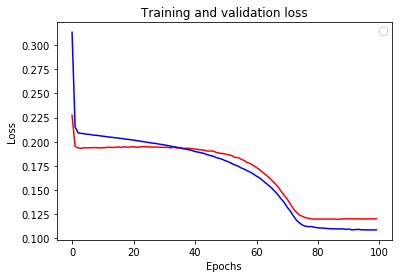

In [452]:
import matplotlib
#plt.plot(ae.history.history['val_loss'], 'r', ae.history.history['loss'], 'b')
plt.plot(model.history.history['val_loss'], 'r',model.history.history['loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [453]:
trainPredict = model.predict(trainX)
yhat = model.predict(testX, verbose=1)
print(yhat)

829/829 [==============================] - 0s 164us/step
[[0.23567626 0.23076287 0.24985433 0.23888394 0.97744703]
 [0.23105347 0.22775304 0.24729413 0.2357969  0.9751705 ]
 [0.23539792 0.2310483  0.25016212 0.23915963 0.976937  ]
 ...
 [0.91315085 0.91530484 0.95781326 0.9284309  0.97914505]
 [0.9165696  0.9190263  0.96317625 0.9324347  0.97901374]
 [0.9258942  0.92882776 0.9750724  0.9421824  0.9786136 ]]


In [454]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(yhat)
testY = scaler.inverse_transform(testY)

In [455]:
print(trainPredict)

[[50.830463   51.43019    50.462017   51.035778    0.97783977]
 [50.354885   50.943924   49.985535   50.551025    0.97771966]
 [49.50847    50.07824    49.135433   49.68694     0.9775139 ]
 ...
 [26.005764   26.201626   25.714214   25.955769    0.978749  ]
 [25.65875    25.910421   25.426266   25.666277    0.9776447 ]
 [25.383896   25.704132   25.24525    25.455906    0.9752733 ]]


In [456]:
print(trainPredict.shape)

(3318, 5)


In [457]:
print(trainY)

[[49.91     50.72     49.8      50.54      1.      ]
 [48.92     49.469997 48.67     49.439995  1.      ]
 [49.099995 49.15     48.04     48.430004  0.      ]
 ...
 [25.729998 25.88     25.25     25.57      1.      ]
 [25.950003 26.25     25.679998 25.799997  1.      ]
 [25.389997 25.94     25.32     25.74      0.      ]]


In [458]:
print(trainY.shape)

(3318, 5)


In [459]:
print(testPredict)

[[25.44897    25.702606   25.21897    25.453362    0.97744703]
 [25.247936   25.5711     25.112923   25.320213    0.9751705 ]
 [25.436865   25.715076   25.231718   25.465254    0.976937  ]
 ...
 [54.91065    55.61196    54.54263    55.19438     0.97914505]
 [55.059315   55.77456    54.764763   55.36707     0.97901374]
 [55.464825   56.20281    55.257504   55.787502    0.9786136 ]]


In [460]:
print(testPredict.shape)

(829, 5)


In [461]:
print(testY)

[[25.750002 25.99     25.47     25.72      1.      ]
 [25.059998 25.8      25.03     25.760002  0.      ]
 [25.610003 25.61     25.08     25.21      1.      ]
 ...
 [55.562504 58.1875   54.6875   56.90625   0.      ]
 [56.78125  58.5625   56.124996 56.3125    0.      ]
 [58.6875   59.3125   56.       58.28125   0.      ]]


In [462]:
print(testY.shape)

(829, 5)


In [463]:
original = (scaler.inverse_transform(train))
#print(scaler.inverse_transform(train))
print(original)

[[51.13     51.72     51.07     51.16      1.      ]
 [50.72     51.3      50.5      51.170002  1.      ]
 [49.91     50.72     49.8      50.54      1.      ]
 ...
 [25.729998 25.88     25.25     25.57      1.      ]
 [25.950003 26.25     25.679998 25.799997  1.      ]
 [25.389997 25.94     25.32     25.74      0.      ]]


In [464]:
Opentrain = original
print(Opentrain[:,:1])
print(Opentrain.shape)


[[51.13    ]
 [50.72    ]
 [49.91    ]
 ...
 [25.729998]
 [25.950003]
 [25.389997]]
(3320, 5)


In [465]:
Hightrain = original
print(Hightrain[:,1:2])

[[51.72]
 [51.3 ]
 [50.72]
 ...
 [25.88]
 [26.25]
 [25.94]]


In [466]:
Lowtrain = original
print(Lowtrain[:,2:3])

[[51.07    ]
 [50.5     ]
 [49.8     ]
 ...
 [25.25    ]
 [25.679998]
 [25.32    ]]


In [467]:
Closetrain = original
print(Closetrain[:,3:4])

[[51.16    ]
 [51.170002]
 [50.54    ]
 ...
 [25.57    ]
 [25.799997]
 [25.74    ]]


In [468]:
original_test = (scaler.inverse_transform(test))
print(scaler.inverse_transform(test))
print(original_test)
print(original_test.shape)

[[25.33     25.64     25.17     25.22      0.      ]
 [25.48     25.72     25.32     25.49      1.      ]
 [25.750002 25.99     25.47     25.72      1.      ]
 ...
 [55.562504 58.1875   54.6875   56.90625   0.      ]
 [56.78125  58.5625   56.124996 56.3125    0.      ]
 [58.6875   59.3125   56.       58.28125   0.      ]]
[[25.33     25.64     25.17     25.22      0.      ]
 [25.48     25.72     25.32     25.49      1.      ]
 [25.750002 25.99     25.47     25.72      1.      ]
 ...
 [55.562504 58.1875   54.6875   56.90625   0.      ]
 [56.78125  58.5625   56.124996 56.3125    0.      ]
 [58.6875   59.3125   56.       58.28125   0.      ]]
(831, 5)


In [469]:
Opentest = original_test
#print(Opentest[:,:1])
print(Opentest.shape)

(831, 5)


In [470]:
Hightest = original_test
#print(Hightest[:,1:2])

In [471]:
Lowtest = original_test
#print(Lowtest[:,2:3])

In [472]:
Closetest = original_test
#print(Closetest[:,3:4])

In [473]:
print(trainPredict)

[[50.830463   51.43019    50.462017   51.035778    0.97783977]
 [50.354885   50.943924   49.985535   50.551025    0.97771966]
 [49.50847    50.07824    49.135433   49.68694     0.9775139 ]
 ...
 [26.005764   26.201626   25.714214   25.955769    0.978749  ]
 [25.65875    25.910421   25.426266   25.666277    0.9776447 ]
 [25.383896   25.704132   25.24525    25.455906    0.9752733 ]]


In [474]:
OpentrainPredict = trainPredict
print(OpentrainPredict[:,:1])

[[50.830463]
 [50.354885]
 [49.50847 ]
 ...
 [26.005764]
 [25.65875 ]
 [25.383896]]


In [475]:
HightrainPredict = trainPredict
print(HightrainPredict[:,1:2])

[[51.43019 ]
 [50.943924]
 [50.07824 ]
 ...
 [26.201626]
 [25.910421]
 [25.704132]]


In [476]:
LowtrainPredict = trainPredict
print(LowtrainPredict[:,2:3])

[[50.462017]
 [49.985535]
 [49.135433]
 ...
 [25.714214]
 [25.426266]
 [25.24525 ]]


In [477]:
ClosetrainPredict = trainPredict
print(ClosetrainPredict[:,3:4])

[[51.035778]
 [50.551025]
 [49.68694 ]
 ...
 [25.955769]
 [25.666277]
 [25.455906]]


In [478]:
OpentestPredict = testPredict
#print(OpentestPredict[:,:1])

In [479]:
HightestPredict = testPredict
#print(HightestPredict[:,1:2])

In [480]:
LowtestPredict = testPredict
#print(LowtestPredict[:,2:3])

In [481]:
ClosetestPredict = testPredict
#print(ClosetestPredict[:,3:4])

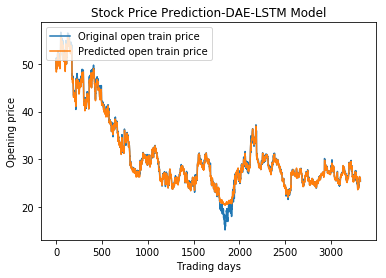

In [482]:
# # shift opentrain predictions for plotting
OpentrainPlot = np.empty_like(Opentrain[:,:1])
OpentrainPlot = Opentrain[:,:1]
# shift OpentrainPredict predictions for plotting
OpentrainPredictPlot = np.empty_like(OpentrainPredict[:,:1])
OpentrainPredictPlot = OpentrainPredict[:,:1]
# # plot baseline and predictions
plt.plot(OpentrainPlot, '', label='Original open train price' )
plt.plot(OpentrainPredictPlot, '', label='Predicted open train price' )
plt.ylabel('Opening price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

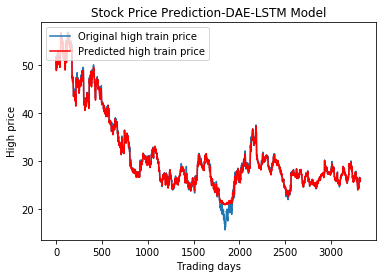

In [483]:
# # shift Hightrain predictions for plotting
HightrainPlot = np.empty_like(Hightrain[:,1:2])
HightrainPlot = Hightrain[:,1:2]
# shift HightrainPredict predictions for plotting
HightrainPredictPlot = np.empty_like(HightrainPredict[:,1:2])
HightrainPredictPlot = HightrainPredict[:,1:2]
# # plot baseline and predictions
plt.plot(HightrainPlot, '', label='Original high train price' )
plt.plot(HightrainPredictPlot, 'r', label='Predicted high train price' )
plt.ylabel('High price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

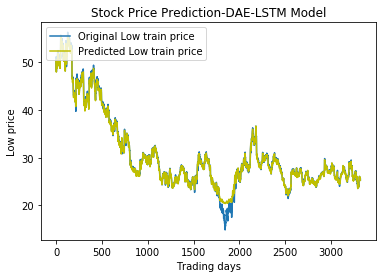

In [484]:
# # shift Lowtrain predictions for plotting
LowtrainPlot = np.empty_like(Lowtrain[:,2:3])
LowtrainPlot = Lowtrain[:,2:3]
# shift LowtrainPredict predictions for plotting
LowtrainPredictPlot = np.empty_like(LowtrainPredict[:,2:3])
LowtrainPredictPlot = LowtrainPredict[:,2:3]
# # plot baseline and predictions
plt.plot(LowtrainPlot, '', label='Original Low train price' )
plt.plot(LowtrainPredictPlot, 'y', label='Predicted Low train price' )
plt.ylabel('Low price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

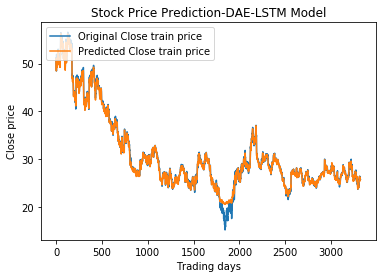

In [485]:
# # shift Closetrain predictions for plotting
ClosetrainPlot = np.empty_like(Closetrain[:,3:4])
ClosetrainPlot = Hightrain[:,3:4]
# shift ClosetrainPredict predictions for plotting
ClosetrainPredictPlot = np.empty_like(ClosetrainPredict[:,3:4])
ClosetrainPredictPlot = ClosetrainPredict[:,3:4]
# # plot baseline and predictions
plt.plot(ClosetrainPlot, '', label='Original Close train price' )
plt.plot(ClosetrainPredictPlot, '', label='Predicted Close train price' )
plt.ylabel('Close price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

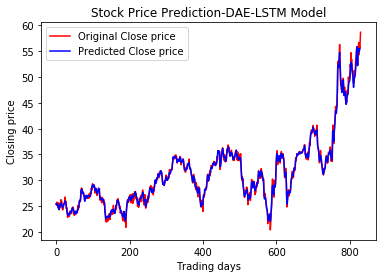

In [486]:

# shift OpentestPredict predictions for plotting
OpentestPlot = np.empty_like(Opentrain[:,:1])
OpentestPlot = Opentest[:,:1]
# shift OpentestPredict predictions for plotting
OpentestPredictPlot = np.empty_like(OpentestPredict[:,:1])
OpentestPredictPlot = OpentestPredict[:,:1]
# # plot baseline and predictions
plt.plot(OpentestPlot, 'r', label='Original Close price' )
plt.plot(OpentestPredictPlot, 'b', label='Predicted Close price' )
plt.ylabel('Closing price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

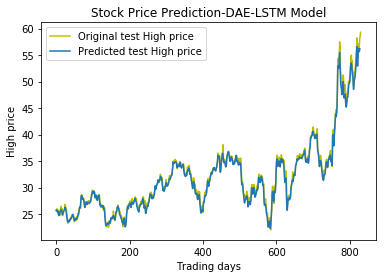

In [487]:
# shift Hightest predictions for plotting
HightestPlot = np.empty_like(Hightest[:,1:2])
HightestPlot = Hightest[:,1:2]
# shift HightestPredict predictions for plotting
HightestPredictPlot = np.empty_like(HightestPredict[:,1:2])
HightestPredictPlot = HightestPredict[:,1:2]
# # plot baseline and predictions
plt.plot(HightestPlot, 'y', label='Original test High price' )
plt.plot(HightestPredictPlot, '', label='Predicted test High price' )
plt.ylabel('High price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

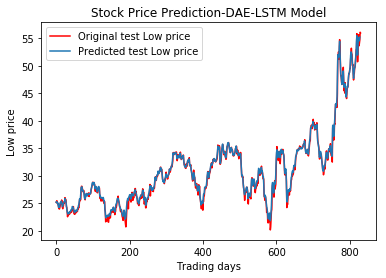

In [488]:
# shift Lowtest predictions for plotting
LowtestPlot = np.empty_like(Lowtest[:,2:3])
LowtestPlot = Lowtest[:,2:3]
# shift LowtrainPredict predictions for plotting
LowtestPredictPlot = np.empty_like(LowtestPredict[:,2:3])
LowtestPredictPlot = LowtestPredict[:,2:3]
# # plot baseline and predictions
plt.plot(LowtestPlot, 'r', label='Original test Low price' )
plt.plot(LowtestPredictPlot, '', label='Predicted test Low price' )
plt.ylabel('Low price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

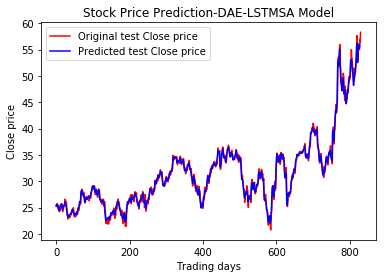

In [489]:
# shift Closetest predictions for plotting
ClosetestPlot = np.empty_like(Closetest[:,3:4])
ClosetestPlot = Closetest[:,3:4]
# shift ClosetrainPredict predictions for plotting
ClosetestPredictPlot = np.empty_like(ClosetestPredict[:,3:4])
ClosetestPredictPlot = ClosetestPredict[:,3:4]
# # plot baseline and predictions
plt.plot(ClosetestPlot, 'r', label='Original test Close price' )
plt.plot(ClosetestPredictPlot, 'b', label='Predicted test Close price' )
plt.ylabel('Close price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTMSA Model')
plt.show()

In [490]:
# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY, testPredict))
# print('Test Score: %.2f RMSE' % (testScore))

In [491]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,:-1], trainPredict[:,:-1]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,:-1], testPredict[:,:-1]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.76 RMSE
Test Score: 1.08 RMSE


In [492]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [493]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict

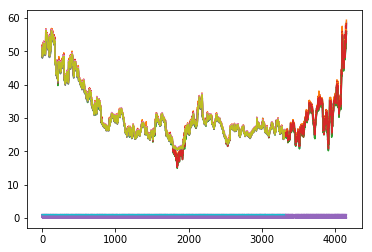

In [494]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [495]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1,:]
print(last_val)
last_val_scaled = last_val/last_val
print(last_val_scaled)


[55.464825  56.20281   55.257504  55.787502   0.9786136]
[1. 1. 1. 1. 1.]


In [496]:
yy = yhat[-2:,:]
yy=yy.reshape((-1,2,5))
print(np.shape(yy))
#print(yy)
nexty = model.predict(yy)
print(nexty)

(1, 2, 5)
[[0.9179517  0.9202195  0.96290815 0.9334767  0.9791126 ]]


In [497]:
actualnexty = scaler.inverse_transform(nexty)
print(actualnexty)

[[55.119423  55.826687  54.75366   55.412018   0.9791126]]


In [498]:
period = 4
yresult = []
yy = yhat[-2:,:]
#yy=yy.reshape((-1,2,4))
for i in range(period):
    yy=yy.reshape((-1,2,5))
    nexty = model.predict(yy)
    #print(nexty)
    actualnexty = scaler.inverse_transform(nexty)
    #print(actualnexty)
    yresult.append(actualnexty[0].tolist())
    yy = yy[0]
    #print(yy)
    yy=np.delete(yy,0,axis=0)
    #print(ary)
    yy=np.insert(yy,1,nexty[0],axis=0)
    #print(yy)
for y in yresult:
    print(y)

[55.119422912597656, 55.82668685913086, 54.753658294677734, 55.412017822265625, 0.9791126251220703]
[55.214149475097656, 55.92555618286133, 54.85236740112305, 55.50969696044922, 0.9790993332862854]
[55.01504898071289, 55.7203483581543, 54.650882720947266, 55.30589294433594, 0.9790719151496887]
[54.9892692565918, 55.6945686340332, 54.62652587890625, 55.27986526489258, 0.9790488481521606]


In [499]:
from sklearn.metrics import mean_absolute_error
Train_MAE = mean_absolute_error(trainY[:,:-1], trainPredict[:,:-1])
print(Train_MAE)
Test_MAE = mean_absolute_error(testY[:,:-1], testPredict[:,:-1])
print(Test_MAE)

0.46543288
0.7401749


In [500]:
#from sklearn.metrics import accuracy_score
#print(testY[:,4:])
#print(accuracy_score(testY[:,:5], testPredict[:,:5]))

In [501]:
#print(testPredict[:,4:])

In [502]:
from sklearn.metrics import r2_score
Train_R2 = r2_score(trainY[:,:-1], trainPredict[:,:-1])
print(Train_R2)
Test_R2 = r2_score(testY[:,:-1], testPredict[:,:-1])
print(Test_R2)

0.9916787743946225
0.9771553684375387


In [503]:
#print(trainY[:,3:-1])

In [504]:
#from sklearn.metrics import accuracy_score
#print(accuracy_score(testY[:,4:], testPredict[:,4:]))

In [505]:
import numpy as np

def mean_absolute_percentage_error_train(trainY, trainPredict): 
    trainY, trainPredict = np.array(trainY[:,:-1]), np.array(trainPredict[:,:-1])
    return np.mean(np.abs((trainY[:,:-1] - trainPredict[:,:-1]) / trainY[:,:-1])) * 100
print(mean_absolute_percentage_error_train(trainY[:,:-1], trainPredict[:,:-1]))

1.6862854361534119


In [506]:
import numpy as np

def mean_absolute_percentage_error_test(testY, testPredict): 
    testY, testPredict = np.array(testY[:,:-1]), np.array(testPredict[:,:-1])
    return np.mean(np.abs((testY[:,:-1] - testPredict[:,:-1]) / testY[:,:-1])) * 100
print(mean_absolute_percentage_error_test(testY[:,:-1], testPredict[:,:-1]))

2.4794703349471092
